In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from tqdm import tqdm

In [6]:
# path = '/content/drive/MyDrive/DATA_SRGAN /mirflickr25k.zip'

In [7]:
# !unzip '/content/drive/MyDrive/DATA_SRGAN /mirflickr25k.zip'  -d '/content/drive/MyDrive/DATA_SRGAN'

In [2]:
print(len(os.listdir('/PBL/PBL6/train')))

5501


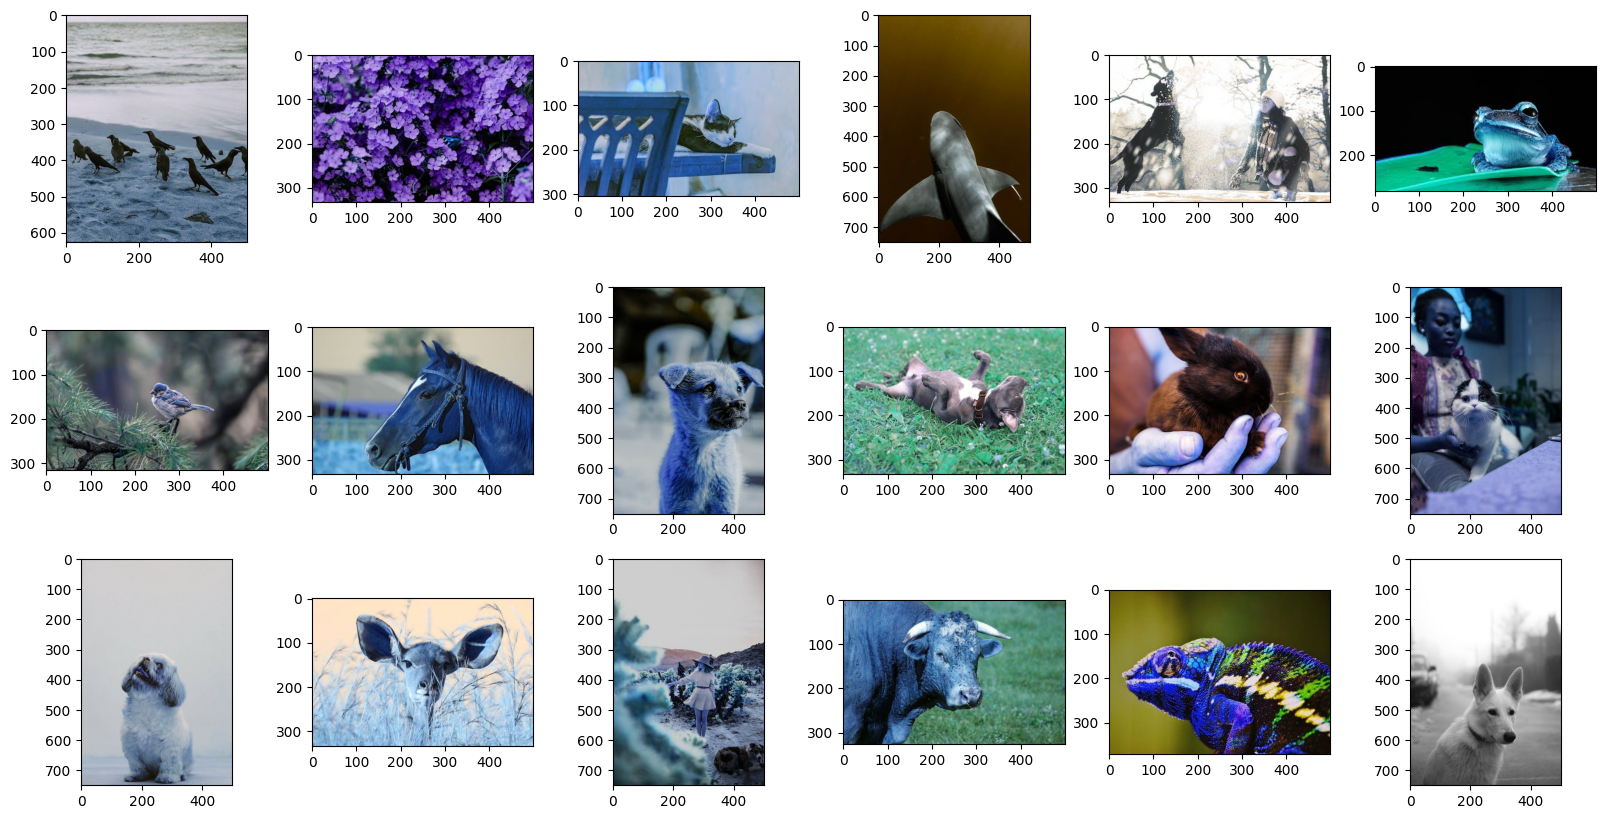

In [3]:
i = 0
imgs = []

for img in os.listdir("/PBL/PBL6/train"):
    img = cv2.imread("/PBL/PBL6/train/" + img )
    img = np.array(img)
    imgs.append(img)
    i+=1
    if i == 19:
        break
plt.figure(figsize=(20,10))
for i in range(18):
    plt.subplot(3,6,i+1)
    plt.imshow(imgs[i])

In [ ]:
sizes = set()
i=0
for img in os.listdir("/PBL/PBL6/train"):
    print(img)
    try:
        img_file = cv2.imread("/PBL/PBL6/train/" + img )
        # sizes.add((img.shape[0],img.shape[1]))
        plt.subplot(2,1,1)
        plt.plot(img_file.shape[0],img_file.shape[1],'.')
        i+=1
        # if img_file.shape[1] == 500 and img_file.shape[0]>=350 and img_file.shape[0]<=650:
        #     cv2.imwrite("/PBL/PBL6/train/" + img,img_file)
        #     plt.subplot(2,1,2)
        #     plt.plot(img_file.shape[0],img_file.shape[1],'.')
    except Exception as e:
        print(e)


# print(len(os.listdir("/PBL/PBL6/train")))
print(i)

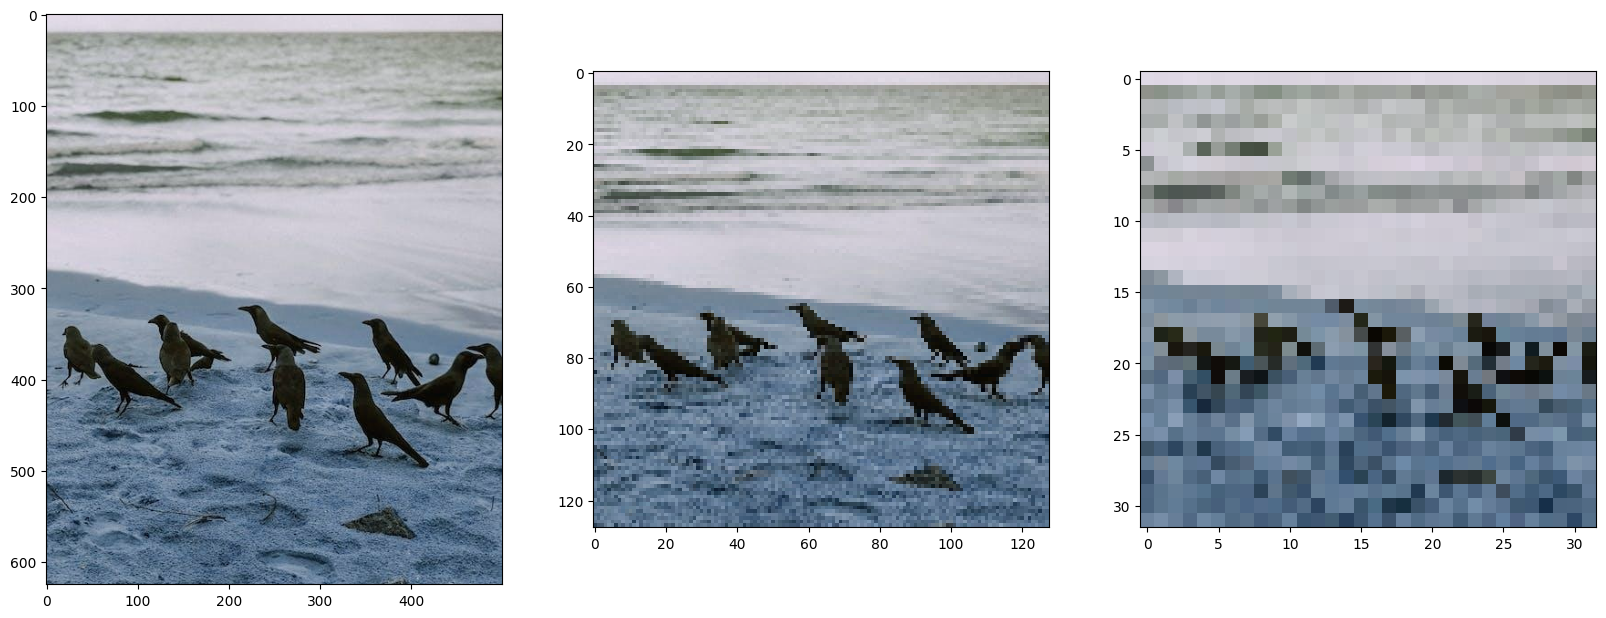

In [19]:
base_img = cv2.imread("/PBL/PBL6/train/ 0.jpg")
# print(base_img.shape)
hr_img = cv2.resize(base_img, (128,128))
lr_img = cv2.resize(base_img, (32,32))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(base_img)
plt.subplot(1,3,2)
plt.imshow(hr_img)
plt.subplot(1,3,3)
plt.imshow(lr_img)

In [10]:
# os.makedirs('/PBL/PBL6/lr_images')

In [11]:
# os.makedirs('/PBL/PBL6/hr_images')

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
# train_dir = '/PBL/PBL6'
# i = 0 

# for img in os.listdir('/content/drive/MyDrive/images2'):

#   if img.endswith('.jpg'):
#     try:
#       img_array = cv2.imread("/content/drive/MyDrive/images2/" + img)

#       img_array = cv2.resize(img_array, (128,128))
#       lr_img_array = cv2.resize(img_array,(32,32))
#       cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)
#       cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)
#     except:
#       continue
#   if i == 4000: 
#     break 
#   i +=1

In [14]:
# print(len(os.listdir('/PBL/PBL6/lr_images')))
# print(len(os.listdir('/PBL/PBL6/hr_images')))

In [15]:
# lr_list = os.listdir("/PBL/PBL6/lr_images")

# lr_images = []
# for img in lr_list:
#     img_lr = cv2.imread("/PBL/PBL6/lr_images/" + img)
#     img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
#     lr_images.append(img_lr)   


# hr_list = os.listdir("/PBL/PBL6/hr_images")
   
# hr_images = []
# for img in hr_list:
#     img_hr = cv2.imread("/PBL/PBL6/hr_images/" + img)
#     img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
#     hr_images.append(img_hr)  

In [16]:
# lr_images = np.array(lr_images)
# hr_images = np.array(hr_images)

In [17]:
# lr_images = lr_images / 255.
# hr_images = hr_images / 255.

In [5]:
import os 
import cv2 
import numpy as np
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from sklearn.model_selection import train_test_split 
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten 
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add 
from keras.utils import plot_model 
from keras import Model 


In [19]:
# define blocks to build the generator 
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [20]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model 

In [21]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [22]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [23]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [24]:
from keras.applications import VGG19

In [25]:
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [26]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [27]:
# os.makedirs('/PBL/PBL6/Data_train_np')

In [28]:
# np.save('/PBL/PBL6/Data_train_np/lr_images.npy', lr_images)
# np.save('/PBL/PBL6/Data_train_np/hr_images.npy', hr_images)


In [6]:
lr_images = np.load('/PBL/PBL6/Data_train_np/lr_images.npy')
hr_images = np.load('/PBL//PBL6/Data_train_np/hr_images.npy')

In [7]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                        test_size=0.1, random_state=42)

In [8]:
np.save('/PBL/PBL6/Data_train_np/lr_test_images.npy', lr_test)
np.save('/PBL/PBL6/Data_train_np/hr_test_images.npy', hr_test)

In [46]:
lr_test = np.load('/PBL/PBL6/Data_train_np/lr_test_images.npy')
hr_test = np.load('/PBL//PBL6/Data_train_np/hr_test_images.npy')

In [10]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

In [11]:
print(hr_shape)

(128, 128, 3)


In [33]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [34]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [35]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [36]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [37]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [38]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

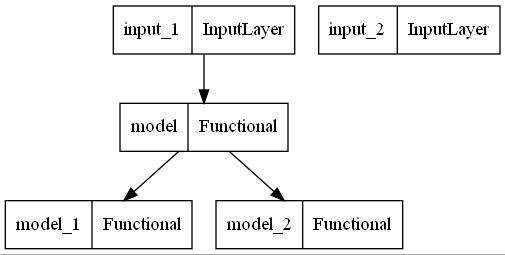

In [39]:
plot_model(gan_model,"model_plot.jpg")

In [40]:
batch_size = 1  
train_lr_batches = []
train_hr_batches = []

In [41]:
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [42]:
# os.makedirs("/PBL/PBL6/save_model")

In [43]:
# os.makedirs('/PBL/PBL6/save_loss')

In [44]:
# save_path = "/PBL/PBL6/save_model/"
# save_path_loss = '/PBL/PBL6/save_loss/'
# epochs = 20 
# #Enumerate training over epochs
# for e in range(epochs):
    
#     fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
#     real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
#     #Create empty lists to populate gen and disc losses. 
#     g_losses = []
#     d_losses = []
    
#     #Enumerate training over batches. 
#     for b in tqdm(range(len(train_hr_batches))):
#         lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
#         hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
#         fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
#         #First, train the discriminator on fake and real HR images. 
#         discriminator.trainable = True
#         d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
#         d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
#         #Now, train the generator by fixing discriminator as non-trainable
#         discriminator.trainable = False
        
#         #Average the discriminator loss, just for reporting purposes. 
#         d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
#         #Extract VGG features, to be used towards calculating loss
#         image_features = vgg.predict(hr_imgs)
     
#         #Train the generator via GAN. 
#         #Remember that we have 2 losses, adversarial loss and content (VGG) loss
#         g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
#         #Save losses to a list so we can average and report. 
#         d_losses.append(d_loss)
#         g_losses.append(g_loss)
        
#     #Convert the list of losses to an array to make it easy to average    
#     g_losses = np.array(g_losses)
#     d_losses = np.array(d_losses)
    
#     #Calculate the average losses for generator and discriminator
#     g_loss = np.sum(g_losses, axis=0) / len(g_losses)
#     d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
#     #Report the progress during training. 
#     print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

#     if (e+1) % 2 == 0: #Change the frequency for model saving, if needed
#         #Save the generator after every n epochs (Usually 10 epochs)
#         generator.save(save_path + "gen_e_"+ str(e+1) +".h5")
#         discriminator.save(save_path + "dis_e_"+ str(e+1) + ".h5")

#     # save loss 
#     d_loss_path = save_path_loss + "d_loss_" + str(e+1) + "npy"
#     g_loss_path = save_path_loss + "g_loss_" + str(e+1) + "npy"
#     np.save(d_loss_path, d_losses) 
#     np.save(g_loss_path, g_losses)

In [41]:
g_loss_list = [] # average per epoch list 

for i in range(10):
  # if loss_file.startswith("g_loss"): 
    g_losses = np.load('/PBL/PBL6/save_loss/d_loss_' + str(i+1)+"npy.npy")
    g_loss = np.sum(g_losses) /len(g_losses)
    g_loss_list.append(g_loss)

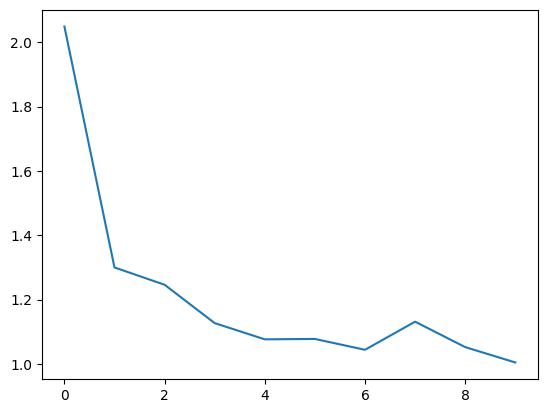

In [42]:
plt.plot(g_loss_list)

In [43]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

In [44]:
generator = load_model('/PBL/PBL6/save_model/gen_e_8.h5', compile=False)

550
[169]
1/1 [==============================] - 0s 125ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 128, 128, 3) (1, 32, 32, 3)


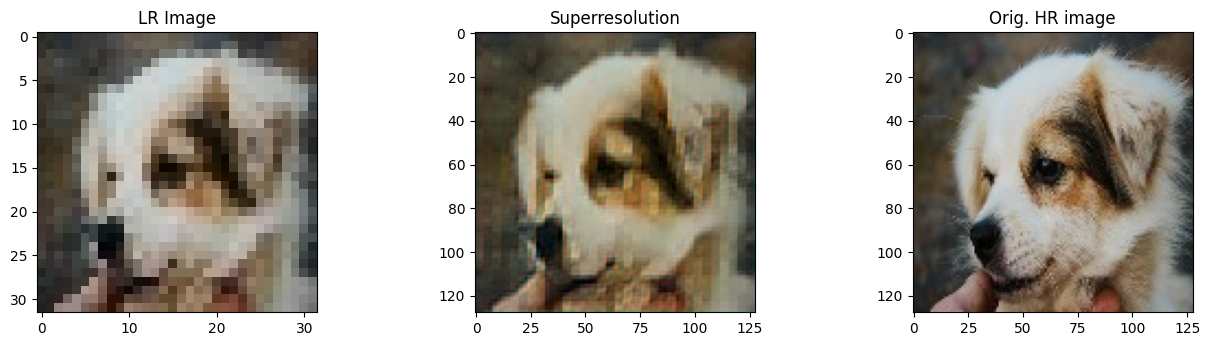

In [52]:
# plot all three images
[X1, X2] = [lr_test, hr_test]

# select random example 
ix = randint(0, len(X1),1)
print(len(X1))
# src_image, tar_image = X1[[91]], X2[[91]]
# ix=[476]
src_image, tar_image = X1[ix], X2[ix]
print(ix)

# generate image from source 
gen_image = generator.predict(src_image)
print(gen_image.shape,src_image.shape)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [50]:
# !zip -r '/content/drive/MyDrive/"PBL.zip"' '/PBL'